In [1]:
# ivfflat range search
import sys
sys.path.append("..")
import h5py
import numpy as np
import faiss
import os
import time
from config import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 

# 实验

In [7]:
# 数据分片
def data_piece(data_choice:str='glove',n_piece:int=5,dim:int=25,nlist:int=100)->dict:# 如果data_choice是glove则dim必须是25,50,100,200，如果是sift则dim必须是128，否则会报错
    n_piece= n_piece#这里是用来定义切片的数量
    data_name= data_expand_info[data_choice][dim] # 这里是为了方便创建文件夹和数据库文件名，方便识别
    glove_file_path = f"../data_expand/{data_name}.hdf5"
    glove_hdf = h5py.File(glove_file_path, "r")# 读取数据
    length_all = len(glove_hdf['train'])# 获取数据的总长度  
    cut_point=int(length_all/n_piece)# 获取切分点,int是向下取整
    data_dict={}# 这里用字典来存取每一段切分点
    for i in range(n_piece):
        data_key=data_name+'_nlist'+str(nlist)+'_n'+str(n_piece)+'_'+str(i+1)
        if i+1 == n_piece:
            data_dict[data_key]=glove_hdf['train'][i*cut_point:]# 把剩下的余数全部纳入不在单独考虑了（如果能整除则恰好每一块长度相同，如果不能整除则最后一段的长度=cut_point+余数），这里是最后一段，
        else:
            data_dict[data_key]=glove_hdf['train'][i*cut_point:(i+1)*cut_point]
    return data_dict,data_name

# 创建存储数据的文件
def create_index_folder_choice(data_name:str,n_piece:int=5,index_style:str='IVFFLat',nlist:int=100)->str:
    folder_path = f"../index_{index_style}_QPS/{data_name}_n{n_piece}_nlist{nlist}"
    # 检查文件夹是否存在
    if not os.path.exists(folder_path):
        # 不存在时创建文件夹
        os.makedirs(folder_path)
        print(f"文件夹 '{folder_path}' 不存在，已创建。")
    else:
        print(f"文件夹 '{folder_path}' 已经存在。")
    return folder_path

# 那我们就定义几个构造的函数，不同类型的向量数据库有不同选择方式，这个通过if条件去判断就行了
def create_index_IVFFLat_QPS(data_choice:str='glove',n_piece:int=5,dim:int=25,nlist:int=100):
    data_dict,data_name=data_piece(data_choice,n_piece,dim,nlist)
    folder_path = create_index_folder_choice(data_name,n_piece,'IVFFlat',nlist)
    for i in range(n_piece):
        data_key=data_name+'_nlist'+str(nlist)+'_n'+str(n_piece)+'_'+str(i+1)
        file_path = f"{folder_path}/{data_key}.index"
        index_factory_str = f"IVF{nlist},Flat"  
        dim = dim
        measure=faiss.METRIC_L2# 这里固定因为glove和sift都用的是L2距离
        index = faiss.index_factory(dim, index_factory_str, measure)  
        df=data_dict[data_key]
        if data_choice=='glove':
            print(f'现在处理的glove数据集{data_key},需要进行归一化处理')
            faiss.normalize_L2(df)
        if not index.is_trained: # 输出为True，代表该类index不需要训练，只需要add向量进去即可
            index.train(df)
            print(f"{data_key}.index 已经训练过了。")
        # 导入数据
        index.add(df)
        faiss.write_index(index, file_path)
        print(f"{data_key}.index 已创建。")

In [8]:
# 创建多组实验所采用的数据集
def get_multiple_data(data_choice:str='glove',dim:int=25,n_piece:list=[5],nlist:list=[128,256,512,1024]):
    npiece=n_piece
    nlist = nlist
    for i in npiece:
        for j in nlist:
            print(i,j)
            create_index_IVFFLat_QPS(data_choice,n_piece=i,dim=dim,nlist=j)

In [9]:
# get_multiple_data(data_choice='glove',dim=25,n_piece=[5,10],nlist=[128,256,512,1024])

5 128
文件夹 '../index_IVFFlat_QPS/glove-25-angular-100000_n5_nlist128' 已经存在。
现在处理的glove数据集glove-25-angular-100000_nlist128_n5_1,需要进行归一化处理
glove-25-angular-100000_nlist128_n5_1.index 已经训练过了。
glove-25-angular-100000_nlist128_n5_1.index 已创建。
现在处理的glove数据集glove-25-angular-100000_nlist128_n5_2,需要进行归一化处理
glove-25-angular-100000_nlist128_n5_2.index 已经训练过了。
glove-25-angular-100000_nlist128_n5_2.index 已创建。
现在处理的glove数据集glove-25-angular-100000_nlist128_n5_3,需要进行归一化处理
glove-25-angular-100000_nlist128_n5_3.index 已经训练过了。
glove-25-angular-100000_nlist128_n5_3.index 已创建。
现在处理的glove数据集glove-25-angular-100000_nlist128_n5_4,需要进行归一化处理
glove-25-angular-100000_nlist128_n5_4.index 已经训练过了。
glove-25-angular-100000_nlist128_n5_4.index 已创建。
现在处理的glove数据集glove-25-angular-100000_nlist128_n5_5,需要进行归一化处理
glove-25-angular-100000_nlist128_n5_5.index 已经训练过了。
glove-25-angular-100000_nlist128_n5_5.index 已创建。
5 256
文件夹 '../index_IVFFlat_QPS/glove-25-angular-100000_n5_nlist256' 已经存在。
现在处理的glove数据集glove-25-angular-100000_nli

In [10]:
# 单个数据处理
def get_test_data_QPS(data_choice:str='glove',dim:int=25,number:int=100,k:int=10):
    data_name= data_expand_info[data_choice][dim] # 这里是为了方便创建文件夹和数据库文件名，方便识别
    glove_file_path = f"../data_expand/{data_name}.hdf5"
    glove_hdf = h5py.File(glove_file_path, "r")# 读取数据
    glove_test = glove_hdf['test'][:number]# 获取测试查询数据
    if data_choice=='glove':
        faiss.normalize_L2(glove_test)# glove数据采用的angular距离，首先需要进行归一化,然后再进行faiss.METRIC_L2
    glove_neighbors = glove_hdf['neighbors'][:number,:k]# 获取测试数据集
    glove_distances = glove_hdf['distances'][:number,:k]# 获取测试数据集
    return glove_test,glove_neighbors,glove_distances

# 获取对应的索引
def get_id(data_choice:str='glove',n_piece:int=5,dim:int=25):
    data_name= data_expand_info[data_choice][dim]
    glove_file_path = f"../data_expand/{data_name}.hdf5"# 数据地址，hdf5格式
    glove_hdf = h5py.File(glove_file_path, "r")# 读取数据
    length_all = len(glove_hdf['train'])# 获取数据的总长度  
    cut_point=int(length_all/n_piece)# 获取切分点,int是向下取整
    id_dict={}# 这里用字典来存取每一段对应的索引
    for i in range(n_piece):
        keys='npiece_'+str(i+1)
        if i+1 == n_piece:
            id=list(range(i*cut_point,length_all))
            id=np.array(id)
            id_dict[keys]=id
        else:
            id=list(range(i*cut_point,(i+1)*cut_point))
            id=np.array(id)
            id_dict[keys]=id
    return id_dict

# 多个数据之间的合并
def combine_list(data: list, ids: list, k: int = 10):
    # 将每个元素和对应ID放在一个元组中
    combined_tuples = [(element, id_val) for element, id_val in zip(data, ids)]
    # 对拼接后的元组列表按照元素排序，sorted是从小到大排序的，正好取前k个即可
    sorted_combined_tuples = sorted(combined_tuples, key=lambda x: x[0])
    # 输出排序后的元素和对应的ID列表
    sorted_elements = [element[0] for element in sorted_combined_tuples]
    sorted_ids = [element[1] for element in sorted_combined_tuples]
    return sorted_elements[:k], sorted_ids[:k]

In [17]:
# 获取搜索结果
def get_search_result_IVFFLat_QPS(data_choice:str='glove',n_piece:int=5,dim:int=25,nlist:int=100,nprobe:int=1,k:int=10,number:int=100):# number是指定测试集的数量,要和get_test_data函数中的number一致
    # data_dict,data_name=data_piece(data_choice,n_piece,dim)
    data_name= data_expand_info[data_choice][dim] 
    folder_path = create_index_folder_choice(data_name,n_piece,'IVFFlat',nlist)
    golve_test,_,_=get_test_data_QPS(data_choice,dim,number,k)# 这是一个双层数组，因为有这么多测试数据集
    # 测试数据提取
    search_id=[]
    search_distance=[]
    id_dict=get_id(data_choice,n_piece,dim)
    for i in range(n_piece):
        data_key=data_name+'_nlist'+str(nlist)+'_n'+str(n_piece)+'_'+str(i+1)
        keys='npiece_'+str(i+1)
        print(f'正在处理数据集{data_key}')
        file_path = f"{folder_path}/{data_key}.index"
        index = faiss.read_index(file_path)
        # 设置搜索参数
        index.nprobe = nprobe
        sd,sid=index.search(golve_test, k)
        id_real=id_dict[keys][sid]
        search_id.append(id_real)
        search_distance.append(sd)
    search_id=np.array(search_id)
    search_distance=np.array(search_distance)
    search_id=np.concatenate(search_id, axis=1)
    search_distance=np.concatenate(search_distance, axis=1)
    # return search_id,search_distance
    # 然后进行排序操作
    test_id=[]
    test_distance=[]
    for i in range(number):
        # print(f'正在处理第{i}个测试数据')
        distance_list,id_list = combine_list(search_distance[i], search_id[i],k)
        test_id.append(id_list) 
        test_distance.append(distance_list)
    test_id=np.array(test_id)
    test_distance=np.array(test_distance)
    return test_id,test_distance

# 计算召回率
def calculate_recall_np(test_id, ground_truth_id):
    tp = len(np.intersect1d(test_id, ground_truth_id))# 返回两个数组中的交集
    recall = tp / len(ground_truth_id) if len(ground_truth_id) != 0 else 0.0
    return recall

# 计算QPS和召回率
def get_QPS(data_choice:str='glove',n_piece:int=5,dim:int=25,nlist:int=100,nprobe:int=1,k:int=10,number:int=100):
    # glove_test,distance_true和neighbors_true暂时没用到
    _,neighbors_true,_=get_test_data_QPS(data_choice,dim,number)# 获取真实id
    start_time = time.time()
    test_id,_=get_search_result_IVFFLat_QPS(data_choice,n_piece,dim,nlist,nprobe,k,number)
    end_time = time.time()
    elapsed_time = end_time - start_time  # 计算查询所需的时间
    # print(test_id.shape,neighbors_true.shape)
    recall_list=[]
    for i in range(number):
        recall=calculate_recall_np(test_id[i],neighbors_true[i])
        recall_list.append(recall)
    mean_reacall=np.mean(recall_list)
    qps=number/elapsed_time
    return mean_reacall,qps

# 多组实验----------------------------------------
# 这里我们通过改变查询参数nprobe来控制召回率
# 构造参数是：nlist

# 进行多组实验：输出一个字典，key是data_key，value是对应的recall和qps
def get_multiple_QPS(data_choice:str='glove',dim:int=25,n_piece:list=[5],nlist: list=[128,256,512,1024],
                     nprobe:list=[1,2,4,6,8,10,15,20,50,100],k:int=10,number:int=1000):
    npiece=n_piece
    nlist = nlist
    nprobe=nprobe
    result_dict={}
    for i in npiece:
        for j in nlist:
            data_name= data_info[data_choice][dim] 
            data_key=data_name+'_nlist'+str(j)+'_n'+str(i)
            result_dict[data_key]={}
            qps=[]
            recall=[]
            for l in nprobe:
                print(i,j,l)
                mean_reacall,qps_=get_QPS(data_choice,n_piece=i,dim=dim,nlist=j,nprobe=l,k=k,number=number)
                qps.append(qps_)
                recall.append(mean_reacall)
            result_dict[data_key]['recall']=np.array(recall)
            result_dict[data_key]['qps']=np.array(qps)
    return result_dict



In [21]:
# 可视化-------------------------------------------
# 创建存储图片所需要的文件夹
def create_photo_store_qps(data_choice:str='glove',dim:int=25,faiss_style:str='IVFFLat')->str:
    data_name= data_info[data_choice][dim]
    folder_path = f"figure/{data_name}_{faiss_style}_QPS"
    # 检查文件夹是否存在
    if not os.path.exists(folder_path):
        # 不存在时创建文件夹
        os.makedirs(folder_path)
        print(f"文件夹 '{folder_path}' 不存在，已创建。")
    else:
        print(f"文件夹 '{folder_path}' 已经存在。")
    return folder_path

def plot_multiple_lines_qps( data_dict: dict, data_choice: str = 'glove', dim: int = 25,faiss_style:str='IVFFLat',k:int=10):
    # 创建文件夹并确定文件路径
    data_name= data_info[data_choice][dim] 
    folder_path = create_photo_store_qps(data_choice, dim,faiss_style)
    file_path = f"{folder_path}/{faiss_style}_k{k}_multiple_lines.png"
    num_lines = len(data_dict)
    # 创建图表对象
    plt.figure(figsize=(8, 5))
    # 使用seaborn颜色板
    colors = sns.color_palette("husl", num_lines)
    # 遍历每条折线图
    for i, (key, inner_dict) in enumerate(data_dict.items()):
        # 提取数据
        x_values = inner_dict['recall']
        y_values = inner_dict['qps']
        # 选择不同颜色，可以根据需要修改颜色
        # line_color = plt.cm.viridis(i / num_lines)
        line_color = colors[i]
        # 在同一个图中绘制多条折线图，并设置标签位置在图外
        sub_label=key
        plt.plot(x_values, y_values, marker='o', label=sub_label, color=line_color)
    # 添加标签和标题
    set_xlabel, set_ylabel = 'Recall', 'query per second(1/s)'
    plt.xlabel(set_xlabel)
    plt.ylabel(set_ylabel)
    plt_title=data_name+'-'+faiss_style+'-QPS'
    plt.title(plt_title)

    # 添加图例，并设置位置在图外
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    # 保存图片
    plt.savefig(file_path, bbox_inches='tight')
    plt.show()




5 128 1
文件夹 '../index_IVFFlat_QPS/glove-25-angular-100000_n5_nlist128' 已经存在。
正在处理数据集glove-25-angular-100000_nlist128_n5_1
正在处理数据集glove-25-angular-100000_nlist128_n5_2
正在处理数据集glove-25-angular-100000_nlist128_n5_3
正在处理数据集glove-25-angular-100000_nlist128_n5_4
正在处理数据集glove-25-angular-100000_nlist128_n5_5
5 128 2
文件夹 '../index_IVFFlat_QPS/glove-25-angular-100000_n5_nlist128' 已经存在。
正在处理数据集glove-25-angular-100000_nlist128_n5_1
正在处理数据集glove-25-angular-100000_nlist128_n5_2
正在处理数据集glove-25-angular-100000_nlist128_n5_3
正在处理数据集glove-25-angular-100000_nlist128_n5_4
正在处理数据集glove-25-angular-100000_nlist128_n5_5
5 128 4
文件夹 '../index_IVFFlat_QPS/glove-25-angular-100000_n5_nlist128' 已经存在。
正在处理数据集glove-25-angular-100000_nlist128_n5_1
正在处理数据集glove-25-angular-100000_nlist128_n5_2
正在处理数据集glove-25-angular-100000_nlist128_n5_3
正在处理数据集glove-25-angular-100000_nlist128_n5_4
正在处理数据集glove-25-angular-100000_nlist128_n5_5
5 128 6
文件夹 '../index_IVFFlat_QPS/glove-25-angular-100000_n5_nlist128' 已经存在。
正在处理数据集glove-25-a

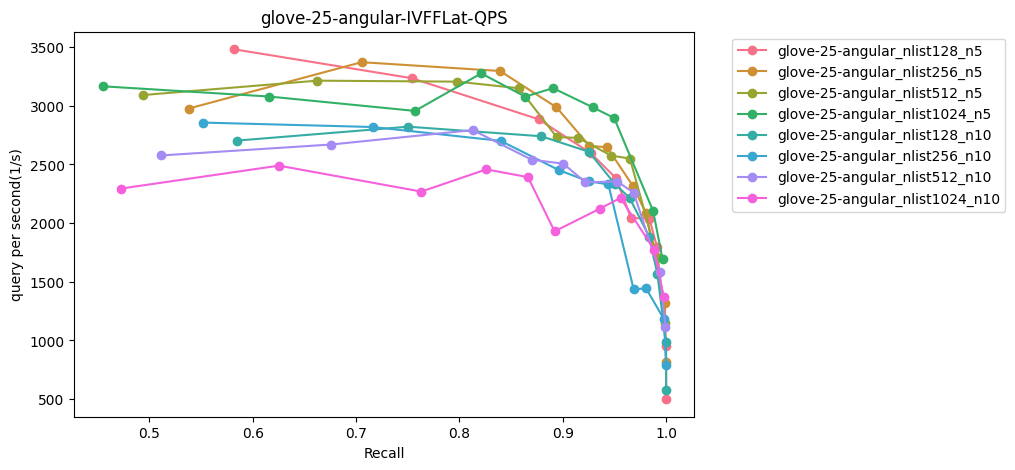

In [22]:
k=10
result_dict=get_multiple_QPS(data_choice='glove',dim=25,n_piece=[5,10],nlist=[128,256,512,1024],k=k)
# 可视化
plot_multiple_lines_qps(result_dict, data_choice='glove', dim=25,faiss_style='IVFFLat')

# 测试nprobe与k返回数量
- 检验了一下召回的向量没有达到topk的会怎样，如何填充
- 测试了faiss.cvar.indexIVF_stats
- 测试了如何根据数据id获取对应的distance，采用zip方法
- 通过检测nprobe的默认值确实是1，直接将get_search_result_IVFFLat_QPS中的index.nprobe = nprobe注释掉然后观察faiss.cvar.indexIVF_stats.ndis即可

In [315]:
# 单个数据处理
# 创建存储数据的文件
def create_index_folder_choice(data_name:str,n_piece:int=5,index_style:str='IVFFLat',nlist:int=100)->str:
    folder_path = f"../index_{index_style}_QPS/{data_name}_n{n_piece}_nlist{nlist}"
    # 检查文件夹是否存在
    if not os.path.exists(folder_path):
        # 不存在时创建文件夹
        os.makedirs(folder_path)
        print(f"文件夹 '{folder_path}' 不存在，已创建。")
    else:
        print(f"文件夹 '{folder_path}' 已经存在。")
    return folder_path

def get_test_data_QPS(data_choice:str='glove',dim:int=25,number:int=100,k:int=10):
    data_name= data_expand_info[data_choice][dim] # 这里是为了方便创建文件夹和数据库文件名，方便识别
    glove_file_path = f"../data_expand/{data_name}.hdf5"
    glove_hdf = h5py.File(glove_file_path, "r")# 读取数据
    glove_test = glove_hdf['test'][:number]# 获取测试查询数据
    if data_choice=='glove':
        faiss.normalize_L2(glove_test)# glove数据采用的angular距离，首先需要进行归一化,然后再进行faiss.METRIC_L2
    glove_neighbors = glove_hdf['neighbors'][:number,:k]# 获取测试数据集
    glove_distances = glove_hdf['distances'][:number,:k]# 获取测试数据集
    return glove_test,glove_neighbors,glove_distances



In [335]:
# 获取搜索结果
def get_search_result_IVFFLat_QPS(data_choice:str='glove',n_piece:int=5,dim:int=25,nlist:int=100,nprobe:int=1,k:int=10,number:int=100):# number是指定测试集的数量,要和get_test_data函数中的number一致
    # data_dict,data_name=data_piece(data_choice,n_piece,dim)
    data_name= data_expand_info[data_choice][dim] 
    folder_path = create_index_folder_choice(data_name,n_piece,'IVFFlat',nlist)
    golve_test,_,_=get_test_data_QPS(data_choice,dim,number,k)# 这是一个双层数组，因为有这么多测试数据集
    for i in range(n_piece):
        data_key=data_name+'_nlist'+str(nlist)+'_n'+str(n_piece)+'_'+str(i+1)
        keys='npiece_'+str(i+1)
        print(f'正在处理数据集{data_key}')
        file_path = f"{folder_path}/{data_key}.index"
        index = faiss.read_index(file_path)
        print(index.ntotal)
        # 设置搜索参数
        index.nprobe = nprobe
        sd,sid=index.search(golve_test, 100000)
        print(sid.shape)
        print(sd[:,:3400])
        print(sid)
        return sd,sid


In [344]:
sd,sid=get_search_result_IVFFLat_QPS(data_choice='glove',n_piece=5,dim=25,nlist=128,nprobe=1,k=10000,number=1)
stats = faiss.cvar.indexIVF_stats
print(stats.ndis)
stats.reset()

文件夹 '../index_IVFFlat_QPS/glove-25-angular-100000_n5_nlist128' 已经存在。
正在处理数据集glove-25-angular-100000_nlist128_n5_1
236702
(1, 100000)
[[0.23566952 0.24144532 0.2839726  ... 1.6194606  1.6280478  1.6560364 ]]
[[ 92191 193105  93058 ...     -1     -1     -1]]
3400


In [318]:
count=0
for i in sid[0]:
    if i==-1:
        count+=1
print(count)
print(np.count_nonzero(sid == -1))

0
0


In [319]:
filtered_distances=[distance for id ,distance in zip(sid[0],sd[0]) if id != -1]
filtered_distances=np.array(filtered_distances)
filtered_distances,len(filtered_distances)

(array([0.23566952, 0.24144532, 0.24168709, ..., 1.4449775 , 1.4449792 ,
        1.4449817 ], dtype=float32),
 100000)

# IVFFLat range search
- 关于范围查询后面还得添加一个新的参数：radius：半径

In [198]:
# 单个数据处理
# 创建存储数据的文件
def create_index_folder_choice(data_name:str,n_piece:int=5,index_style:str='IVFFLat',nlist:int=100)->str:
    folder_path = f"../index_{index_style}_QPS/{data_name}_n{n_piece}_nlist{nlist}"
    # 检查文件夹是否存在
    if not os.path.exists(folder_path):
        # 不存在时创建文件夹
        os.makedirs(folder_path)
        print(f"文件夹 '{folder_path}' 不存在，已创建。")
    else:
        print(f"文件夹 '{folder_path}' 已经存在。")
    return folder_path

def get_test_data_QPS(data_choice:str='glove',dim:int=25,number:int=100,k:int=10):
    data_name= data_expand_info[data_choice][dim] # 这里是为了方便创建文件夹和数据库文件名，方便识别
    glove_file_path = f"../data_expand/{data_name}.hdf5"
    glove_hdf = h5py.File(glove_file_path, "r")# 读取数据
    glove_test = glove_hdf['test'][:number]# 获取测试查询数据
    if data_choice=='glove':
        faiss.normalize_L2(glove_test)# glove数据采用的angular距离，首先需要进行归一化,然后再进行faiss.METRIC_L2
    glove_neighbors = glove_hdf['neighbors'][:number,:k]# 获取测试数据集
    glove_distances = glove_hdf['distances'][:number,:k]# 获取测试数据集
    return glove_test,glove_neighbors,glove_distances


In [221]:
# # 获取搜索结果
# def get_search_result_IVFFLat_QPS(data_choice:str='glove',n_piece:int=5,dim:int=25,nlist:int=100,nprobe:int=1,k:int=10,number:int=100):# number是指定测试集的数量,要和get_test_data函数中的number一致
#     # data_dict,data_name=data_piece(data_choice,n_piece,dim)
#     data_name= data_expand_info[data_choice][dim] 
#     folder_path = create_index_folder_choice(data_name,n_piece,'IVFFlat',nlist)
#     golve_test,_,_=get_test_data_QPS(data_choice,dim,number,k)# 这是一个双层数组，因为有这么多测试数据集
#     for i in range(n_piece):
#         data_key=data_name+'_nlist'+str(nlist)+'_n'+str(n_piece)+'_'+str(i+1)
#         keys='npiece_'+str(i+1)
#         print(f'正在处理数据集{data_key}')
#         file_path = f"{folder_path}/{data_key}.index"
#         index = faiss.read_index(file_path)
#         print(index.ntotal)
#         # 设置搜索参数
#         print(golve_test.shape)
#         index.nprobe = nprobe
#         _,sd,sid=index.range_search(golve_test, 0.5)
#         print(sid.shape)
#         print(sd.shape)
#         # print(sid)
#         return sd,sid


In [377]:
# 增加了一层for循环
# 反正要遍历两层，将query数量放在外面会增加对数据库加载的时间，本来只要加载npiece次，现在要加载number*npiece次
def get_search_result_IVFFLat_QPS(data_choice:str='glove',n_piece:int=5,dim:int=25,nlist:int=100,nprobe:int=1,k:int=10,number:int=100):# number是指定测试集的数量,要和get_test_data函数中的number一致
    # data_dict,data_name=data_piece(data_choice,n_piece,dim)
    data_name= data_expand_info[data_choice][dim] 
    folder_path = create_index_folder_choice(data_name,n_piece,'IVFFlat',nlist)
    golve_test,_,_=get_test_data_QPS(data_choice,dim,number,k)# 这是一个双层数组，因为有这么多测试数据集
    sd,sid=[],[]
    for i in range(n_piece):
        # sid_number,sd_number= [],[]
        data_key=data_name+'_nlist'+str(nlist)+'_n'+str(n_piece)+'_'+str(i+1)
        # print(f'正在处理数据集{data_key}')
        file_path = f"{folder_path}/{data_key}.index"
        index = faiss.read_index(file_path)
        # print(index.ntotal)
        print(i)
        for j in range(number):
            # 设置搜索参数
            index.nprobe = nprobe
            _,sd_,sid_=index.range_search(golve_test[j:j+1], 0.1)
            
            if i==0:
                sd.append(sd_)
                sid.append(sid_)
            else:
                sd_=np.concatenate((sd[j],sd_))
                sid_=np.concatenate((sid[j],sid_))
                sd[j]=(sd_)
                sid[j]=(sid_)
            # print(sd_.shape,sd[j].shape)
            return sd,sid


In [378]:
sd,sid=get_search_result_IVFFLat_QPS(data_choice='glove',n_piece=5,dim=25,nlist=128,nprobe=128,k=10000,number=1000)
stats = faiss.cvar.indexIVF_stats
print(stats.ndis)
a=stats.ndis
stats.reset()
# print(a,stats.ndis)

文件夹 '../index_IVFFlat_QPS/glove-25-angular-100000_n5_nlist128' 已经存在。
0
236702


In [379]:
sd

[array([], dtype=float32)]

# 对比实验

In [9]:
# 创建存储数据的文件
def create_index_folder_choice(data_name:str,n_piece:int=5,index_style:str='IVFFLat',nlist:int=100)->str:
    folder_path = f"../index_{index_style}_QPS/{data_name}_n{n_piece}_nlist{nlist}"
    # 检查文件夹是否存在
    if not os.path.exists(folder_path):
        # 不存在时创建文件夹
        os.makedirs(folder_path)
        print(f"文件夹 '{folder_path}' 不存在，已创建。")
    else:
        print(f"文件夹 '{folder_path}' 已经存在。")
    return folder_path

## 纯top k的方法

In [18]:
# 单个数据处理
def get_test_data_QPS(data_choice:str='glove',dim:int=25,number:int=100,k:int=10):
    data_name= data_expand_info[data_choice][dim] # 这里是为了方便创建文件夹和数据库文件名，方便识别
    glove_file_path = f"../data_expand/{data_name}.hdf5"
    glove_hdf = h5py.File(glove_file_path, "r")# 读取数据
    glove_test = glove_hdf['test'][:number]# 获取测试查询数据
    if data_choice=='glove':
        faiss.normalize_L2(glove_test)# glove数据采用的angular距离，首先需要进行归一化,然后再进行faiss.METRIC_L2
    glove_neighbors = glove_hdf['neighbors'][:number,:k]# 获取测试数据集
    glove_distances = glove_hdf['distances'][:number,:k]# 获取测试数据集
    return glove_test,glove_neighbors,glove_distances

# 获取对应的索引
def get_id(data_choice:str='glove',n_piece:int=5,dim:int=25):
    data_name= data_expand_info[data_choice][dim]
    glove_file_path = f"../data_expand/{data_name}.hdf5"# 数据地址，hdf5格式
    glove_hdf = h5py.File(glove_file_path, "r")# 读取数据
    length_all = len(glove_hdf['train'])# 获取数据的总长度  
    cut_point=int(length_all/n_piece)# 获取切分点,int是向下取整
    id_dict={}# 这里用字典来存取每一段对应的索引
    for i in range(n_piece):
        keys='npiece_'+str(i+1)
        if i+1 == n_piece:
            id=list(range(i*cut_point,length_all))
            id=np.array(id)
            id_dict[keys]=id
        else:
            id=list(range(i*cut_point,(i+1)*cut_point))
            id=np.array(id)
            id_dict[keys]=id
    return id_dict

# 多个数据之间的合并
def combine_list(data: list, ids: list, k: int = 10):
    # 将每个元素和对应ID放在一个元组中
    combined_tuples = [(element, id_val) for element, id_val in zip(data, ids)]
    # 对拼接后的元组列表按照元素排序，sorted是从小到大排序的，正好取前k个即可
    sorted_combined_tuples = sorted(combined_tuples, key=lambda x: x[0])
    # 输出排序后的元素和对应的ID列表
    sorted_elements = [element[0] for element in sorted_combined_tuples]
    sorted_ids = [element[1] for element in sorted_combined_tuples]
    return sorted_elements[:k], sorted_ids[:k]

In [24]:
# 获取搜索结果
def get_search_result_IVFFLat_QPS(data_choice:str='glove',n_piece:int=5,dim:int=25,nlist:int=100,
                                  nprobe:int=1,k:int=10000,number:int=100,topk:int=10000):
    # data_dict,data_name=data_piece(data_choice,n_piece,dim)
    data_name= data_expand_info[data_choice][dim] 
    folder_path = create_index_folder_choice(data_name,n_piece,'IVFFlat',nlist)
    golve_test,_,_=get_test_data_QPS(data_choice,dim,number,k)# 这是一个双层数组，因为有这么多测试数据集
    # 测试数据提取
    search_id=[]
    search_distance=[]
    id_dict=get_id(data_choice,n_piece,dim)
    for i in range(n_piece):
        data_key=data_name+'_nlist'+str(nlist)+'_n'+str(n_piece)+'_'+str(i+1)
        keys='npiece_'+str(i+1)
        # print(f'正在处理数据集{data_key}')
        file_path = f"{folder_path}/{data_key}.index"
        index = faiss.read_index(file_path)
        # 设置搜索参数
        index.nprobe = nprobe
        sd,sid=index.search(golve_test, topk)
        id_real=id_dict[keys][sid]
        search_id.append(id_real)
        search_distance.append(sd)
    search_id=np.array(search_id)
    search_distance=np.array(search_distance)
    search_id=np.concatenate(search_id, axis=1)
    search_distance=np.concatenate(search_distance, axis=1)
    # return search_id,search_distance
    # 然后进行排序操作
    test_id=[]
    test_distance=[]
    for i in range(number):
        # print(f'正在处理第{i}个测试数据')
        distance_list,id_list = combine_list(search_distance[i], search_id[i],k)
        test_id.append(id_list) 
        test_distance.append(distance_list)
    test_id=np.array(test_id)
    test_distance=np.array(test_distance)
    return test_id,test_distance

# 计算召回率
def calculate_recall_np(test_id, ground_truth_id):
    tp = len(np.intersect1d(test_id, ground_truth_id))# 返回两个数组中的交集
    recall = tp / len(ground_truth_id) if len(ground_truth_id) != 0 else 0.0
    return recall

# 计算QPS和召回率
def get_QPS(data_choice:str='glove',n_piece:int=5,dim:int=25,nlist:int=100,nprobe:int=1,k:int=10000,number:int=100,topk:int=10000):
    # glove_test,distance_true和neighbors_true暂时没用到
    _,neighbors_true,_=get_test_data_QPS(data_choice,dim,number)# 获取真实id
    # 需要对faiss进行重置，避免累加
    stats = faiss.cvar.indexIVF_stats
    stats.reset()
    test_id,_=get_search_result_IVFFLat_QPS(data_choice,n_piece,dim,nlist,nprobe,k,number,topk)
    stats = faiss.cvar.indexIVF_stats
    calculate_ndis=stats.ndis
    stats.reset()
    recall_list=[]
    for i in range(number):
        recall=calculate_recall_np(test_id[i],neighbors_true[i])
        recall_list.append(recall)
    mean_reacall=np.mean(recall_list)
    qps=calculate_ndis
    return mean_reacall,qps




In [27]:
# 多组实验----------------------------------------
# 这里我们通过改变查询参数nprobe来控制召回率
# 构造参数是：nlist
# 根据nlist来构造nprobe

def get_nprobe_list(nlist):# 返回一个字典,这是针对nprobe_range的
    nprobe_dict={}
    # 我们生成10个数的列表
    for i in nlist:
        initial_list=[1,2,4,6,8,12,16,32,64]
        nprobe_list=[j*int(i/64) for j in initial_list]
        nprobe_dict[i]=nprobe_list
    return nprobe_dict

# 进行多组实验：输出一个字典，key是data_key，value是对应的recall和qps
def get_multiple_QPS(data_choice:str='glove',dim:int=25,n_piece:list=[10],nlist: list=[128,256,512,1024],
                     nprobe:dict=get_nprobe_list([128,256,512,1024]),k:int=10000,number:int=1000,topk:int=10000):
    result_dict={}
    for i in n_piece:
        for j in nlist:
            data_name= data_info[data_choice][dim] 
            data_key=data_name+'_nlist'+str(j)+'_n'+str(i)+'topk'
            result_dict[data_key]={}
            cal_ndis=[]
            recall=[]
            for l in nprobe[j]:
                print(i,j,l)
                mean_reacall,ndis=get_QPS(data_choice,n_piece=i,dim=dim,nlist=j,nprobe=l,k=k,number=number,topk=topk)
                cal_ndis.append(ndis)
                recall.append(mean_reacall)
            result_dict[data_key]['recall']=np.array(recall)
            result_dict[data_key]['ndis']=np.array(cal_ndis)
    return result_dict

In [ ]:
# k=10000
# topk=5000
# nlist=[128,256,512,1024]
# result_topk=get_multiple_QPS(data_choice='glove',dim=25,n_piece=[10],nlist=nlist,k=k,
#                                 nprobe=get_nprobe_list(nlist),number=1000,topk=topk)

## range和top k混合的搜索
- nporbe还与nlist相关，看看如何修改更为合理

In [2]:

# 单个数据处理
def get_test_data_ndis(data_choice:str='glove',dim:int=25,number:int=100,k:int=10):
    data_name= data_expand_info[data_choice][dim] # 这里是为了方便创建文件夹和数据库文件名，方便识别
    glove_file_path = f"../data_expand/{data_name}.hdf5"
    glove_hdf = h5py.File(glove_file_path, "r")# 读取数据
    glove_test = glove_hdf['test'][:number]# 获取测试查询数据
    if data_choice=='glove':
        faiss.normalize_L2(glove_test)# glove数据采用的angular距离，首先需要进行归一化,然后再进行faiss.METRIC_L2
    glove_neighbors = glove_hdf['neighbors'][:number,:k]# 获取测试数据集
    glove_distances = glove_hdf['distances'][:number,:k]# 获取测试数据集
    return glove_test,glove_neighbors,glove_distances

# 获取对应的索引
def get_id(data_choice:str='glove',n_piece:int=5,dim:int=25):
    data_name= data_expand_info[data_choice][dim]
    glove_file_path = f"../data_expand/{data_name}.hdf5"# 数据地址，hdf5格式
    glove_hdf = h5py.File(glove_file_path, "r")# 读取数据
    length_all = len(glove_hdf['train'])# 获取数据的总长度  
    cut_point=int(length_all/n_piece)# 获取切分点,int是向下取整
    id_dict={}# 这里用字典来存取每一段对应的索引
    for i in range(n_piece):
        keys='npiece_'+str(i+1)
        if i+1 == n_piece:
            id=list(range(i*cut_point,length_all))
            id=np.array(id)
            id_dict[keys]=id
        else:
            id=list(range(i*cut_point,(i+1)*cut_point))
            id=np.array(id)
            id_dict[keys]=id
    return id_dict

# 多个数据之间的合并
def combine_list(data: list, ids: list, k: int = 10):
    # 将每个元素和对应ID放在一个元组中
    combined_tuples = [(element, id_val) for element, id_val in zip(data, ids)]
    # 对拼接后的元组列表按照元素排序，sorted是从小到大排序的，正好取前k个即可
    sorted_combined_tuples = sorted(combined_tuples, key=lambda x: x[0])
    # 输出排序后的元素和对应的ID列表
    sorted_elements = [element[0] for element in sorted_combined_tuples]
    sorted_ids = [element[1] for element in sorted_combined_tuples]
    if len(sorted_elements) < k:
        # print(f"Warning: The number of elements is less than {k}.")
        return sorted_elements, sorted_ids
    else:
        return sorted_elements[:k], sorted_ids[:k]  

In [3]:
# 计算mad：中位数绝对偏差
def mad_thread(distance,initial_thread,mad_k):
    median=np.median(distance)
    distance_change=np.abs(distance-median)
    mad=np.median(distance_change)
    thread=initial_thread+mad_k*mad
    return thread

In [4]:
# # 就是第一个分片用top k
# # 后面的分片用range search
# # 增加2个参数：topk(用于第一个top k 查询),mad_k(用于后面的range_search：MAD方法)
# # 修改参数：nprobe为nprobe_topk和nprobe_range
# # 这里我们也是采用一个双层循环，因为每个query计算出来的结果都不一样
# def get_search_result_IVFFLat_QPS(data_choice:str='glove',n_piece:int=5,dim:int=25,nlist:int=100
#                                   ,nprobe_topk:int=1,nprobe_range:int=1
#                                   ,k:int=10,number:int=100,topk:int=10000,mad_k:int=3):
#     data_name= data_expand_info[data_choice][dim] 
#     folder_path = create_index_folder_choice(data_name,n_piece,'IVFFlat',nlist)
#     golve_test,_,_=get_test_data_QPS(data_choice,dim,number,k)
#     id_dict=get_id(data_choice,n_piece,dim)
#     search_id=[]
#     search_distance=[]
#     for i in range(n_piece):
#         data_key=data_name+'_nlist'+str(nlist)+'_n'+str(n_piece)+'_'+str(i+1)
#         keys='npiece_'+str(i+1)
#         # print(f'正在处理数据集{data_key}')
#         file_path = f"{folder_path}/{data_key}.index"
#         index = faiss.read_index(file_path)
#         for j in range(number):
#             if i==0:# 第一层采用 topk
#                 index.nprobe = nprobe_topk
#                 sd,sid=index.search(golve_test[j:j+1], topk)# 此时的sd和sid都是一个双层array
#                 out_sapce=np.where(sid[0]==-1)[0]# 这里是指用-1填充的位置，因为不足的就会用-1填充
#                 if out_sapce.size==0:# 表示是一个空的array,表示没有要填充的位置
#                     sid=id_dict[keys][sid]
#                     search_distance.append(sd[0])
#                     search_id.append(sid[0])
#                 else:
#                     sid=sid[:,:out_sapce[0]]# 这里是把-1填充的位置去掉
#                     sid=id_dict[keys][sid]
#                     # print(sid.shape)
#                     search_distance.append(sd[0][:out_sapce[0]])
#                     search_id.append(sid[0][:out_sapce[0]])
#             else:# 第层采用 range_search
#                 index.nprobe = nprobe_range
#                 initial_threshold=min(search_distance[j])
#                 threshold=mad_thread(search_distance[j],initial_threshold,mad_k)
#                 _,sd,sid=index.range_search(golve_test[j:j+1], threshold)
#                 sid=id_dict[keys][sid]
#                 # print(sid.shape)
#                 sd_=np.concatenate((search_distance[j],sd))
#                 sid_=np.concatenate((search_id[j],sid))
#                 search_distance[j]=(sd_)
#                 search_id[j]=(sid_)
#             print(i,j,search_id[j].shape,search_distance[j].shape)
#     return search_id,search_distance
# search_id,search_distance=get_search_result_IVFFLat_QPS(data_choice='glove',n_piece=5,dim=25,nlist=128
#         ,nprobe_topk=128,nprobe_range=100,k=10000,number=1,topk=10000,mad_k=3)
# stats = faiss.cvar.indexIVF_stats
# print(stats.ndis)
# a=stats.ndis
# stats.reset()
# print(stats.ndis)
# len(search_id),len(search_distance)


In [5]:
# 就是第一个分片用top k
# 后面的分片用range search
# 增加2个参数：topk(用于第一个top k 查询),mad_k(用于后面的range_search：MAD方法)
# 修改参数：nprobe为nprobe_topk和nprobe_range
# 这里我们也是采用一个双层循环，因为每个query计算出来的结果都不一样
def get_search_result_IVFFLat(data_choice:str='glove',n_piece:int=5,dim:int=25,nlist:int=100
                                  ,nprobe_topk:int=1,nprobe_range:int=1
                                  ,k:int=10,number:int=100,topk:int=10000,mad_k:int=3):
    data_name= data_expand_info[data_choice][dim] 
    folder_path = create_index_folder_choice(data_name,n_piece,'IVFFlat',nlist)
    golve_test,_,_=get_test_data_ndis(data_choice,dim,number,k)
    id_dict=get_id(data_choice,n_piece,dim)
    search_id=[]
    search_distance=[]
    for i in range(n_piece):
        data_key=data_name+'_nlist'+str(nlist)+'_n'+str(n_piece)+'_'+str(i+1)
        keys='npiece_'+str(i+1)
        # print(f'正在处理数据集{data_key}')
        file_path = f"{folder_path}/{data_key}.index"
        index = faiss.read_index(file_path)
        for j in range(number):
            if i==0:# 第一层采用 topk
                index.nprobe = nprobe_topk
                sd,sid=index.search(golve_test[j:j+1], topk)# 此时的sd和sid都是一个双层array
                out_sapce=np.where(sid[0]==-1)[0]# 这里是指用-1填充的位置，因为不足的就会用-1填充
                if out_sapce.size==0:# 表示是一个空的array,表示没有要填充的位置
                    sid=id_dict[keys][sid]
                    search_distance.append(sd[0])
                    search_id.append(sid[0])
                else:
                    sid=sid[:,:out_sapce[0]]# 这里是把-1填充的位置去掉
                    sid=id_dict[keys][sid]
                    # print(sid.shape)
                    search_distance.append(sd[0][:out_sapce[0]])
                    search_id.append(sid[0][:out_sapce[0]])
               
                # 如果nprobe_topk>=nlist,就不用再进行range_search了，意味着遍历了所有的类别所有的数据了
                # 这里是对不同的分片不是同一个分片，所以这个操作没有意义
                # print(nprobe_topk,nlist)
                # if nprobe_topk >= nlist:
                #     print('nprobe_topk>=nlist',nprobe_topk,nlist)
                #     break
            else:# 第层采用 range_search
                index.nprobe = nprobe_range
                initial_threshold=min(search_distance[j])
                threshold=mad_thread(search_distance[j],initial_threshold,mad_k)
                _,sd,sid=index.range_search(golve_test[j:j+1], threshold)
                sid=id_dict[keys][sid]
                # print(sid.shape)
                sd_=np.concatenate((search_distance[j],sd))
                sid_=np.concatenate((search_id[j],sid))
                search_distance[j]=(sd_)
                search_id[j]=(sid_)
            # print(i,j,search_id[j].shape,search_distance[j].shape)
    # 然后进行排序操作
    test_id=[]
    test_distance=[]
    for i in range(number):
        # print(f'正在处理第{i}个测试数据')
        distance_list,id_list = combine_list(search_distance[i], search_id[i],k)
        test_id.append(np.array(id_list) )
        test_distance.append(distance_list)
    return test_id,test_distance

# 计算召回率
def calculate_recall_np(test_id, ground_truth_id):
    tp = len(np.intersect1d(test_id, ground_truth_id))# 返回两个数组中的交集
    recall = tp / len(ground_truth_id) if len(ground_truth_id) != 0 else 0.0
    return recall

# 计算QPS和召回率
def get_ndis_recall(data_choice:str='glove',n_piece:int=5,dim:int=25,nlist:int=100,
            nprobe_topk:int=1,nprobe_range:int=1,
            k:int=10,number:int=100,topk:int=10000,mad_k:int=3):
    # glove_test,distance_true和neighbors_true暂时没用到
    _,neighbors_true,_=get_test_data_ndis(data_choice,dim,number)# 获取真实id
    # 需要对faiss进行重置，避免累加
    stats = faiss.cvar.indexIVF_stats
    stats.reset()
    test_id,_=get_search_result_IVFFLat(data_choice,n_piece,dim,nlist,nprobe_topk,nprobe_range,k,number,topk,mad_k)
    stats = faiss.cvar.indexIVF_stats
    calculate_ndis=stats.ndis
    stats.reset()
    recall_list=[]
    for i in range(number):
        recall=calculate_recall_np(test_id[i],neighbors_true[i])
        recall_list.append(recall)
    mean_reacall=np.mean(recall_list)
    return mean_reacall,calculate_ndis

In [6]:
# # test_id,test_distance=get_search_result_IVFFLat(data_choice='glove',n_piece=5,dim=25,nlist=128
# #         ,nprobe_topk=1,nprobe_range=1,k=10000,number=1,topk=10000,mad_k=3)
# mean_reacall,calculate_ndis=get_ndis_recall(data_choice='glove',n_piece=5,dim=25,nlist=128
#                                             ,nprobe_topk=128,nprobe_range=7,k=10000,number=1,topk=10000,mad_k=3)
# print(mean_reacall,calculate_ndis)

In [16]:
# 进行多组实验：输出一个字典，key是data_key，value是对应的recall和qps
# 不知道是用dict好还是list好
# nlist中的元素最好是2的幂次方，同时最小为64

# 定义nprobe索引
def get_nprobe_range_list(nlist):# 返回一个字典,这是针对nprobe_range的
    nprobe_dict={}
    # 我们生成10个数的列表
    for i in nlist:
        initial_list=[1,2,4,6,8,12,16,32,64]
        nprobe_list=[j*int(i/64) for j in initial_list]
        nprobe_dict[i]=nprobe_list
    return nprobe_dict
def get_nprobe_top_k(nlist):# 返回一个字典,这是针对nprobe_topk的
    nprobe_dict={}
    for i in nlist:
        nprobe_list=[int(i/10)]
        nprobe_dict[i]=nprobe_list
    return nprobe_dict


def get_multiple_ndis(data_choice:str='glove',dim:int=25,n_piece:list=[5],nlist: list=[128,256,512,1024],
                     nprobe_topk:dict=get_nprobe_top_k([128,256,512,1024]),nprobe_range:dict=get_nprobe_range_list([128,256,512,1024])
                     ,k:int=10,number:int=1000,topk:int=10000,mad_k:int=3):
    result_dict={}
    for i in n_piece:
        for j in nlist:
            data_name= data_info[data_choice][dim] 
            data_key=data_name+'_nlist'+str(j)+'_n'+str(i)+'_topk&range'
            result_dict[data_key]={}
            cal_ndis=[]
            recall=[]
            for l in nprobe_topk[j]:
                for m in nprobe_range[j]:
                    print(i,j,l,m)
                    mean_reacall,ndis=get_ndis_recall(data_choice,n_piece=i,dim=dim,nlist=j,
                        nprobe_topk=l,nprobe_range=m,k=k,number=number,topk=topk,mad_k=mad_k)
                    cal_ndis.append(ndis)
                    recall.append(mean_reacall)
            result_dict[data_key]['recall']=np.array(recall)
            result_dict[data_key]['ndis']=np.array(cal_ndis)
    return result_dict

In [33]:
# k=10000
# nlist=[128,256,512,1024]
# ''' 
# 我们最好是固定nprobe_topk，然后变换nprobe_range。因为nprobe_topk只控制了第一个分片，所以说重要性没后面的大
# ''' 

# result_range_topk=get_multiple_ndis(data_choice='glove',dim=25,n_piece=[10],nlist=nlist,
#                         nprobe_topk=get_nprobe_top_k(nlist),nprobe_range=get_nprobe_range_list(nlist),k=10000,number=100,topk=10000,mad_k=3)

## 获取实验结果

In [36]:
# 纯topk方法结果获取
k=10000
topk=5000
nlist=[128,256,512,1024]
result_topk=get_multiple_QPS(data_choice='glove',dim=25,n_piece=[10],nlist=nlist,k=k,
                                nprobe=get_nprobe_list(nlist),number=1000,topk=topk)

10 128 2
文件夹 '../index_IVFFlat_QPS/glove-25-angular-100000_n10_nlist128' 已经存在。
10 128 4
文件夹 '../index_IVFFlat_QPS/glove-25-angular-100000_n10_nlist128' 已经存在。
10 128 8
文件夹 '../index_IVFFlat_QPS/glove-25-angular-100000_n10_nlist128' 已经存在。
10 128 12
文件夹 '../index_IVFFlat_QPS/glove-25-angular-100000_n10_nlist128' 已经存在。
10 128 16
文件夹 '../index_IVFFlat_QPS/glove-25-angular-100000_n10_nlist128' 已经存在。
10 128 24
文件夹 '../index_IVFFlat_QPS/glove-25-angular-100000_n10_nlist128' 已经存在。
10 128 32
文件夹 '../index_IVFFlat_QPS/glove-25-angular-100000_n10_nlist128' 已经存在。
10 128 64
文件夹 '../index_IVFFlat_QPS/glove-25-angular-100000_n10_nlist128' 已经存在。
10 128 128
文件夹 '../index_IVFFlat_QPS/glove-25-angular-100000_n10_nlist128' 已经存在。
10 256 4
文件夹 '../index_IVFFlat_QPS/glove-25-angular-100000_n10_nlist256' 已经存在。
10 256 8
文件夹 '../index_IVFFlat_QPS/glove-25-angular-100000_n10_nlist256' 已经存在。
10 256 16
文件夹 '../index_IVFFlat_QPS/glove-25-angular-100000_n10_nlist256' 已经存在。
10 256 24
文件夹 '../index_IVFFlat_QPS/glove-25

In [34]:
# topk和range_search方法结果获取
k=10000
nlist=[128,256,512,1024]
topk=5000
result_range_topk=get_multiple_ndis(data_choice='glove',dim=25,n_piece=[10],nlist=nlist,
                        nprobe_topk=get_nprobe_top_k(nlist),nprobe_range=get_nprobe_range_list(nlist),k=10000,number=100,topk=10000,mad_k=3)

10 128 12 2
文件夹 '../index_IVFFlat_QPS/glove-25-angular-100000_n10_nlist128' 已经存在。
10 128 12 4
文件夹 '../index_IVFFlat_QPS/glove-25-angular-100000_n10_nlist128' 已经存在。
10 128 12 8
文件夹 '../index_IVFFlat_QPS/glove-25-angular-100000_n10_nlist128' 已经存在。
10 128 12 12
文件夹 '../index_IVFFlat_QPS/glove-25-angular-100000_n10_nlist128' 已经存在。
10 128 12 16
文件夹 '../index_IVFFlat_QPS/glove-25-angular-100000_n10_nlist128' 已经存在。
10 128 12 24
文件夹 '../index_IVFFlat_QPS/glove-25-angular-100000_n10_nlist128' 已经存在。
10 128 12 32
文件夹 '../index_IVFFlat_QPS/glove-25-angular-100000_n10_nlist128' 已经存在。
10 128 12 64
文件夹 '../index_IVFFlat_QPS/glove-25-angular-100000_n10_nlist128' 已经存在。
10 128 12 128
文件夹 '../index_IVFFlat_QPS/glove-25-angular-100000_n10_nlist128' 已经存在。
10 256 25 4
文件夹 '../index_IVFFlat_QPS/glove-25-angular-100000_n10_nlist256' 已经存在。
10 256 25 8
文件夹 '../index_IVFFlat_QPS/glove-25-angular-100000_n10_nlist256' 已经存在。
10 256 25 16
文件夹 '../index_IVFFlat_QPS/glove-25-angular-100000_n10_nlist256' 已经存在。
10 256 2

In [37]:
# 实验结果拼接
merge_result={**result_topk,**result_range_topk}

## 可视化

In [13]:
# 可视化-------------------------------------------
# 创建存储图片所需要的文件夹
def create_photo_store_qps(data_choice:str='glove',dim:int=25,faiss_style:str='IVFFLat')->str:
    data_name= data_info[data_choice][dim]
    folder_path = f"figure/{data_name}_{faiss_style}_QPS"
    # 检查文件夹是否存在
    if not os.path.exists(folder_path):
        # 不存在时创建文件夹
        os.makedirs(folder_path)
        print(f"文件夹 '{folder_path}' 不存在，已创建。")
    else:
        print(f"文件夹 '{folder_path}' 已经存在。")
    return folder_path

# 这里打算对比两组实验，一个是用top k的方法，另一个使用range-search的方法

def plot_multiple_lines_qps( data_dict: dict, data_choice: str = 'glove', dim: int = 25,faiss_style:str='IVFFLat',k:int=10):
    # 创建文件夹并确定文件路径
    data_name= data_info[data_choice][dim] 
    folder_path = create_photo_store_qps(data_choice, dim,faiss_style)
    file_path = f"{folder_path}/{faiss_style}_k{k}_multiple_lines.png"
    num_lines = len(data_dict)
    # 创建图表对象
    plt.figure(figsize=(8, 5))
    # 使用seaborn颜色板
    colors = sns.color_palette("husl", num_lines)
    # 遍历每条折线图
    for i, (key, inner_dict) in enumerate(data_dict.items()):
        # 提取数据
        x_values = inner_dict['recall']
        y_values = inner_dict['ndis']/(10**8)
        # 选择不同颜色，可以根据需要修改颜色
        # line_color = plt.cm.viridis(i / num_lines)
        line_color = colors[i]
        # 在同一个图中绘制多条折线图，并设置标签位置在图外
        sub_label=key
        plt.plot(x_values, y_values, marker='o', label=sub_label, color=line_color)
    # 添加标签和标题
    set_xlabel, set_ylabel = 'Recall', 'Number of calculations'
    plt.xlabel(set_xlabel)
    plt.ylabel(set_ylabel)
    plt_title=data_name+'-'+faiss_style+'-Number of calculations'
    plt.title(plt_title)

    # 添加图例，并设置位置在图外
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    # 保存图片
    plt.savefig(file_path, bbox_inches='tight')
    plt.show()

文件夹 'figure/glove-25-angular_IVFFLat_all_QPS' 不存在，已创建。


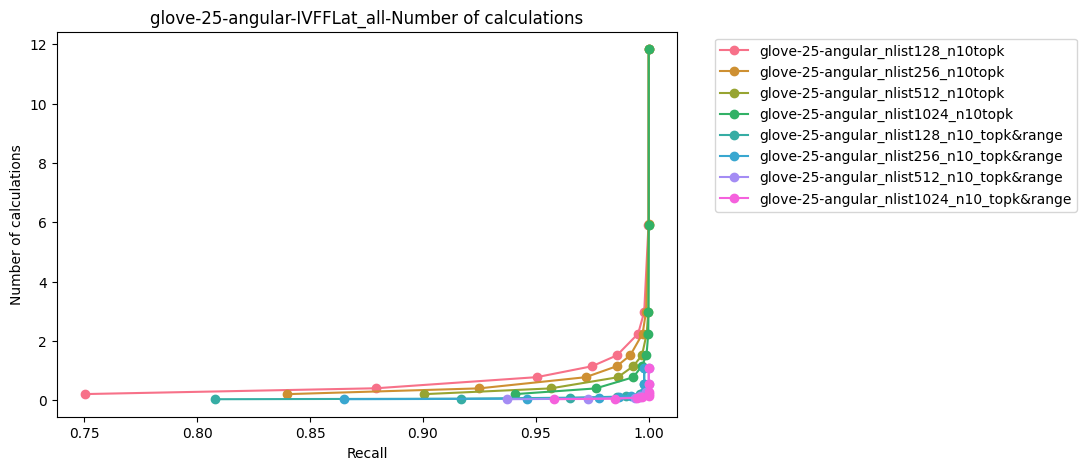

In [44]:
# 可视化
# plot_multiple_lines_qps(result_range_topk, data_choice='glove', dim=25,faiss_style='IVFFLat')
plot_multiple_lines_qps(merge_result, data_choice='glove', dim=25,faiss_style='IVFFLat_all',k=5000)

文件夹 'figure/glove-25-angular_IVFFLat_topk_QPS' 不存在，已创建。


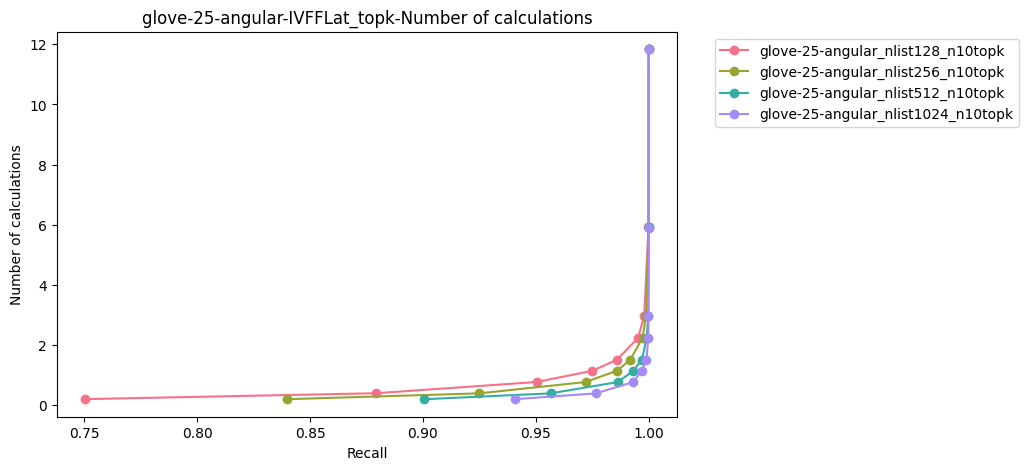

In [45]:
# 纯topk
plot_multiple_lines_qps(result_topk, data_choice='glove', dim=25,faiss_style='IVFFLat_topk',k=5000)

文件夹 'figure/glove-25-angular_IVFFLat_topk&range_QPS' 不存在，已创建。


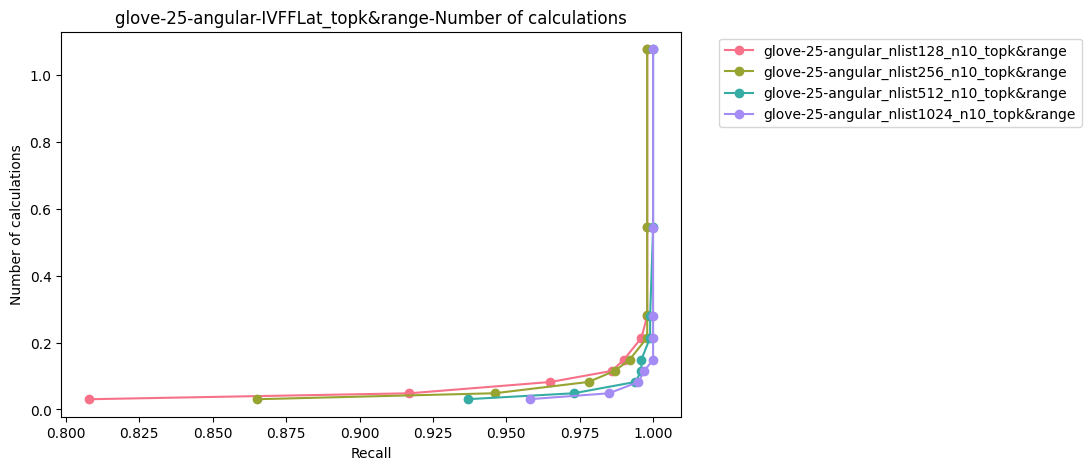

In [46]:
# topk和range_search方法结果获取
plot_multiple_lines_qps(result_range_topk, data_choice='glove', dim=25,faiss_style='IVFFLat_topk&range',k=5000)